#### Step 0 dowload important library

In [ ]:
!pip install kagglehub numpy pandas scikit-learn matplotlib seaborn tldextract textblob python-whois

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 7.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_path = "drive/MyDrive/Colab Notebooks/maliscious_url_save_files"
import os

# Step 1 download Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sid321axn/malicious-urls-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/malicious-urls-dataset


In [ ]:
import os
import numpy as np
import pandas as pd

df = pd.read_csv(os.path.join(path, "malicious_phish.csv"))
print(df.head())
print('=' * 150)
print(df.info())
print('=' * 150)
print(df['type'].value_counts())

                                                 url        type
0                                   br-icloud.com.br    phishing
1                mp3raid.com/music/krizz_kaliko.html      benign
2                    bopsecrets.org/rexroth/cr/1.htm      benign
3  http://www.garage-pirenne.be/index.php?option=...  defacement
4  http://adventure-nicaragua.net/index.php?optio...  defacement
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB
None
type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64


In [ ]:
print('dublicates url = ',df.duplicated().sum())
print('null urls = ',df.isnull().sum())
df.drop_duplicates(inplace=True)
df.dropna()
print('=' * 150)
print("after deleting dublicates and nulls:-")
print('dublicates url = ',df.duplicated().sum())
print('null urls = ',df.isnull().sum())

dublicates url =  10066
null urls =  url     0
type    0
dtype: int64
after deleting dublicates and nulls:-
dublicates url =  0
null urls =  url     0
type    0
dtype: int64


# Step **2** extracting features

#### Importing Libraries and files

In [ ]:
import re
import socket
from urllib.parse import urlparse
import whois
import datetime
import ssl
import tldextract

#### Feature extraction functions

In [ ]:
#extract_features.py
import logging

# Suppress logging from 'whois'
logging.getLogger("whois").setLevel(logging.CRITICAL)
try:
    with open(os.path.join(drive_path,"top-1m.csv"), "r") as f:
        top_domains = {line.strip().split(',')[1] for line in f}
    print("loaded")
except:
    print("cant load")
    top_domains = None
#lexical
def extract_lexical_features(url):
    if not url.startswith(('http://', 'https://')):
        url_ = 'http://' + url
    else:
        url_ = url
    try:
        parsed = urlparse(url_)

    except:
        parsed = urlparse(url)
    hostname = parsed.hostname or ""
    ext = tldextract.extract(url_)
    domain = f"{ext.domain}.{ext.suffix}"


    # suspicious tld - https://www.cybercrimeinfocenter.org/top-20-tlds-by-malicious-phishing-domains
    suspicious_tlds = {'zip', 'xyz', 'tk', 'top', 'gq', 'ga', 'ml', 'cyou', 'buzz', 'cf', 'icu', 'wang', 'live'}

    return {
        "url":url,
        "domain": domain,
        #len>75
        "url_length": len(url),
        #len>50
        "hostname_length": len(hostname),
        #num>1
        "num_dots": url.count('.'),
        #num>1
        "num_hyphens": url.count('-'),
        #http
        "has_https": int(url.startswith("https")),
        #num>4
        "num_subdirs": url.count('/'),
        #num>8
        "num_digits": sum(c.isdigit() for c in url),
        #num>4
        "num_params": url.count('='),
        #num>1
        "num_fragments": url.count('#'),
        #num>10
        "num_uppercase": sum(c.isupper() for c in url),
        #yes
        "has_ip": int(bool(re.search(r'\d+\.\d+\.\d+\.\d+', url))),
        #yes
        "has_port": int(':' in hostname),
        #yes
        "is_encoded": int('%' in url),
        #no
        "starts_with_www": int(hostname.startswith("www")),
        #yes
        "ends_with_suspicious_tld": int(ext.suffix in suspicious_tlds),

        #suspicious words - https://www.researchgate.net/figure/Suspicious-words-to-detect-phishing-URLs_fig6_364265241
        "suspicious_words": int(any(w in url.lower() for w in ['login', 'verify', 'account', 'update', 'secure', 'bank', 'lucky', 'bonus', 'gift', 'signin']))
    }
try:
    context = ssl.create_default_context()
except:
    context=None
#host based
def extract_host_features(domain):
    features = {
        "domain_age_days": -1,
        "dns_record_exists": 0,
        "has_ssl_certificate": 0,
        "is_alexa_top": 0
    }
    # dom age
    try:
        w = whois.whois(domain)
        creation_date = w.creation_date
        if isinstance(creation_date, list):
            creation_date = creation_date[0]
        if creation_date:
            age = (datetime.datetime.now() - creation_date).days
            features["domain_age_days"] = age
    except:
        pass
    # DNS Check
    try:
        socket.gethostbyname(domain)
        features["dns_record_exists"] = 1
    except:
        pass
    # ssl check
    try:
        if context:
            with socket.create_connection((domain, 443), timeout=3) as sock:
                with context.wrap_socket(sock, server_hostname=domain) as ssock:
                    features["has_ssl_certificate"] = 1
    except:
        pass
    # alexa top
    if top_domains:
        features["is_alexa_top"] = int(domain in top_domains)
    return features

#main func
def extract_all_features(url):
    lexical_features = extract_lexical_features(url)
    host_features = extract_host_features(lexical_features["domain"])
    return {**lexical_features, **host_features}


loaded


#### Extracting lexical features

In [ ]:
import pandas as pd
from tqdm import tqdm

# Sample 10% from each class in the 'label' column
sample_ratio = 1
sample_df = df.groupby('type', group_keys=False).apply(lambda x: x.sample(frac=sample_ratio, random_state=42))
tqdm.pandas()  # adds a progress bar to apply

# Apply feature extraction
lexical_features_df = sample_df['url'].progress_apply(lambda url: pd.Series(extract_lexical_features(url)))
lexical_features_df.head()
unique_domains = lexical_features_df["domain"].unique()
#extract_features_df = unique_domain['domain'].progress_apply(lambda domain: pd.Series(extract_host_features(domain)))
# Concatenate with original DataFrame (optional)
df_with_features = pd.merge(sample_df, lexical_features_df, on='url')
df_with_features.head()

/tmp/ipython-input-7-3047814602.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df.groupby('type', group_keys=False).apply(lambda x: x.sample(frac=sample_ratio, random_state=42))
100%|██████████| 641125/641125 [03:21<00:00, 3176.70it/s]


,url,type,domain,url_length,hostname_length,num_dots,num_hyphens,has_https,num_subdirs,num_digits,num_params,num_fragments,num_uppercase,has_ip,has_port,is_encoded,starts_with_www,ends_with_suspicious_tld,suspicious_words
0,cybermuse.gallery.ca/cybermuse/search/artist_e...,benign,gallery.ca,65,0,3,0,0,3,4,1,0,0,0,0,0,0,0,0
1,fanpix.net/gallery/paul-gleason-pictures.htm,benign,fanpix.net,44,0,2,2,0,2,0,0,0,0,0,0,0,0,0,0
2,biogs.com/strictlycomedancing/bellingham.html,benign,biogs.com,45,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0
3,mylife.com/c-1090135275,benign,mylife.com,23,0,1,1,0,1,10,0,0,0,0,0,0,0,0,0
4,mcshane-construction.com/leadership.aspx,benign,mcshane-construction.com,40,0,2,1,0,1,0,0,0,0,0,0,0,0,0,0


#### Extracting Host features

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

results = {}
with ThreadPoolExecutor(max_workers=1000) as executor:
    futures = {executor.submit(extract_host_features, d): d for d in unique_domains}

    for future in tqdm(as_completed(futures), total=len(futures)):
        domain = futures[future]
        try :
            results[domain] = future.result()
        except:
            results[domain] = None

# To convert to DataFrame:
host_features_df = pd.DataFrame.from_dict(results, orient='index').reset_index().rename(columns={"index": "domain"})
host_features_df.head()






100%|██████████| 155574/155574 [02:27<00:00, 1054.86it/s]


,domain,dns_record_exists,has_ssl_certificate,is_alexa_top
0,panelphysicians.com,1,1,0
1,kjrh.com,1,1,0
2,villedesorel.tel,0,0,0
3,dobermantalk.com,1,1,0
4,newsmax.com,1,1,0


In [ ]:
for column in host_features_df.columns:
    if column != "domain":
        print(column, host_features_df[column].value_counts())

dns_record_exists dns_record_exists
1    98486
0    57088
Name: count, dtype: int64
has_ssl_certificate has_ssl_certificate
0    80343
1    75231
Name: count, dtype: int64
is_alexa_top is_alexa_top
0    155574
Name: count, dtype: int64


In [ ]:

df_with_features = pd.merge(df_with_features, host_features_df, on='domain')
df_with_features["label"] = df_with_features["type"].apply(lambda t:1 if t == 'benign' else 0)

df_with_features.head()



,url,type,domain,url_length,hostname_length,num_dots,num_hyphens,has_https,num_subdirs,num_digits,...,has_ip,has_port,is_encoded,starts_with_www,ends_with_suspicious_tld,suspicious_words,dns_record_exists,has_ssl_certificate,is_alexa_top,label
0,cybermuse.gallery.ca/cybermuse/search/artist_e...,benign,gallery.ca,65,0,3,0,0,3,4,...,0,0,0,0,0,0,1,1,0,1
1,fanpix.net/gallery/paul-gleason-pictures.htm,benign,fanpix.net,44,0,2,2,0,2,0,...,0,0,0,0,0,0,1,1,0,1
2,biogs.com/strictlycomedancing/bellingham.html,benign,biogs.com,45,0,2,0,0,2,0,...,0,0,0,0,0,0,1,1,0,1
3,mylife.com/c-1090135275,benign,mylife.com,23,0,1,1,0,1,10,...,0,0,0,0,0,0,1,0,0,1
4,mcshane-construction.com/leadership.aspx,benign,mcshane-construction.com,40,0,2,1,0,1,0,...,0,0,0,0,0,0,1,1,0,1


In [ ]:
df_with_features.to_csv(os.path.join(drive_path,'extracted_dataset.csv'), index=False)

### removing less correlated columns

In [ ]:
extracted_dataset = pd.read_csv(os.path.join(drive_path,'extracted_dataset.csv'))
extracted_dataset.head()

,url,type,domain,url_length,num_dots,num_hyphens,has_https,num_subdirs,num_digits,num_params,...,is_encoded,starts_with_www,ends_with_suspicious_tld,suspicious_words,domain_age_days,dns_record_exists,has_ssl_certificate,is_alexa_top,label,hostname_length
0,cybermuse.gallery.ca/cybermuse/search/artist_e...,benign,gallery.ca,65,3,0,0,3,4,1,...,0,0,0,0,9032,0,0,0,1,20
1,fanpix.net/gallery/paul-gleason-pictures.htm,benign,fanpix.net,44,2,2,0,2,0,0,...,0,0,0,0,-1,1,0,0,1,10
2,biogs.com/strictlycomedancing/bellingham.html,benign,biogs.com,45,2,0,0,2,0,0,...,0,0,0,0,-1,1,0,0,1,9
3,mylife.com/c-1090135275,benign,mylife.com,23,1,1,0,1,10,0,...,0,0,0,0,-1,1,1,1,1,10
4,mcshane-construction.com/leadership.aspx,benign,mcshane-construction.com,40,2,1,0,1,0,0,...,0,0,0,0,-1,1,0,0,1,24


In [ ]:
extract_all_features('biogs.com/strictlycomedancing/bellingham.html')

{'url': 'biogs.com/strictlycomedancing/bellingham.html',
 'domain': 'biogs.com',
 'url_length': 45,
 'hostname_length': 9,
 'num_dots': 2,
 'num_hyphens': 0,
 'has_https': 0,
 'num_subdirs': 2,
 'num_digits': 0,
 'num_params': 0,
 'num_fragments': 0,
 'num_uppercase': 0,
 'has_ip': 0,
 'has_port': 0,
 'is_encoded': 0,
 'starts_with_www': 0,
 'ends_with_suspicious_tld': 0,
 'suspicious_words': 0,
 'domain_age_days': 8382,
 'dns_record_exists': 1,
 'has_ssl_certificate': 1,
 'is_alexa_top': 0}

In [ ]:
extracted_dataset.columns

Index(['url', 'type', 'domain', 'url_length', 'num_dots', 'num_hyphens',
       'has_https', 'num_subdirs', 'num_digits', 'num_params', 'num_fragments',
       'num_uppercase', 'has_ip', 'has_port', 'is_encoded', 'starts_with_www',
       'ends_with_suspicious_tld', 'suspicious_words', 'domain_age_days',
       'dns_record_exists', 'has_ssl_certificate', 'is_alexa_top', 'label',
       'hostname_length'],
      dtype='object')

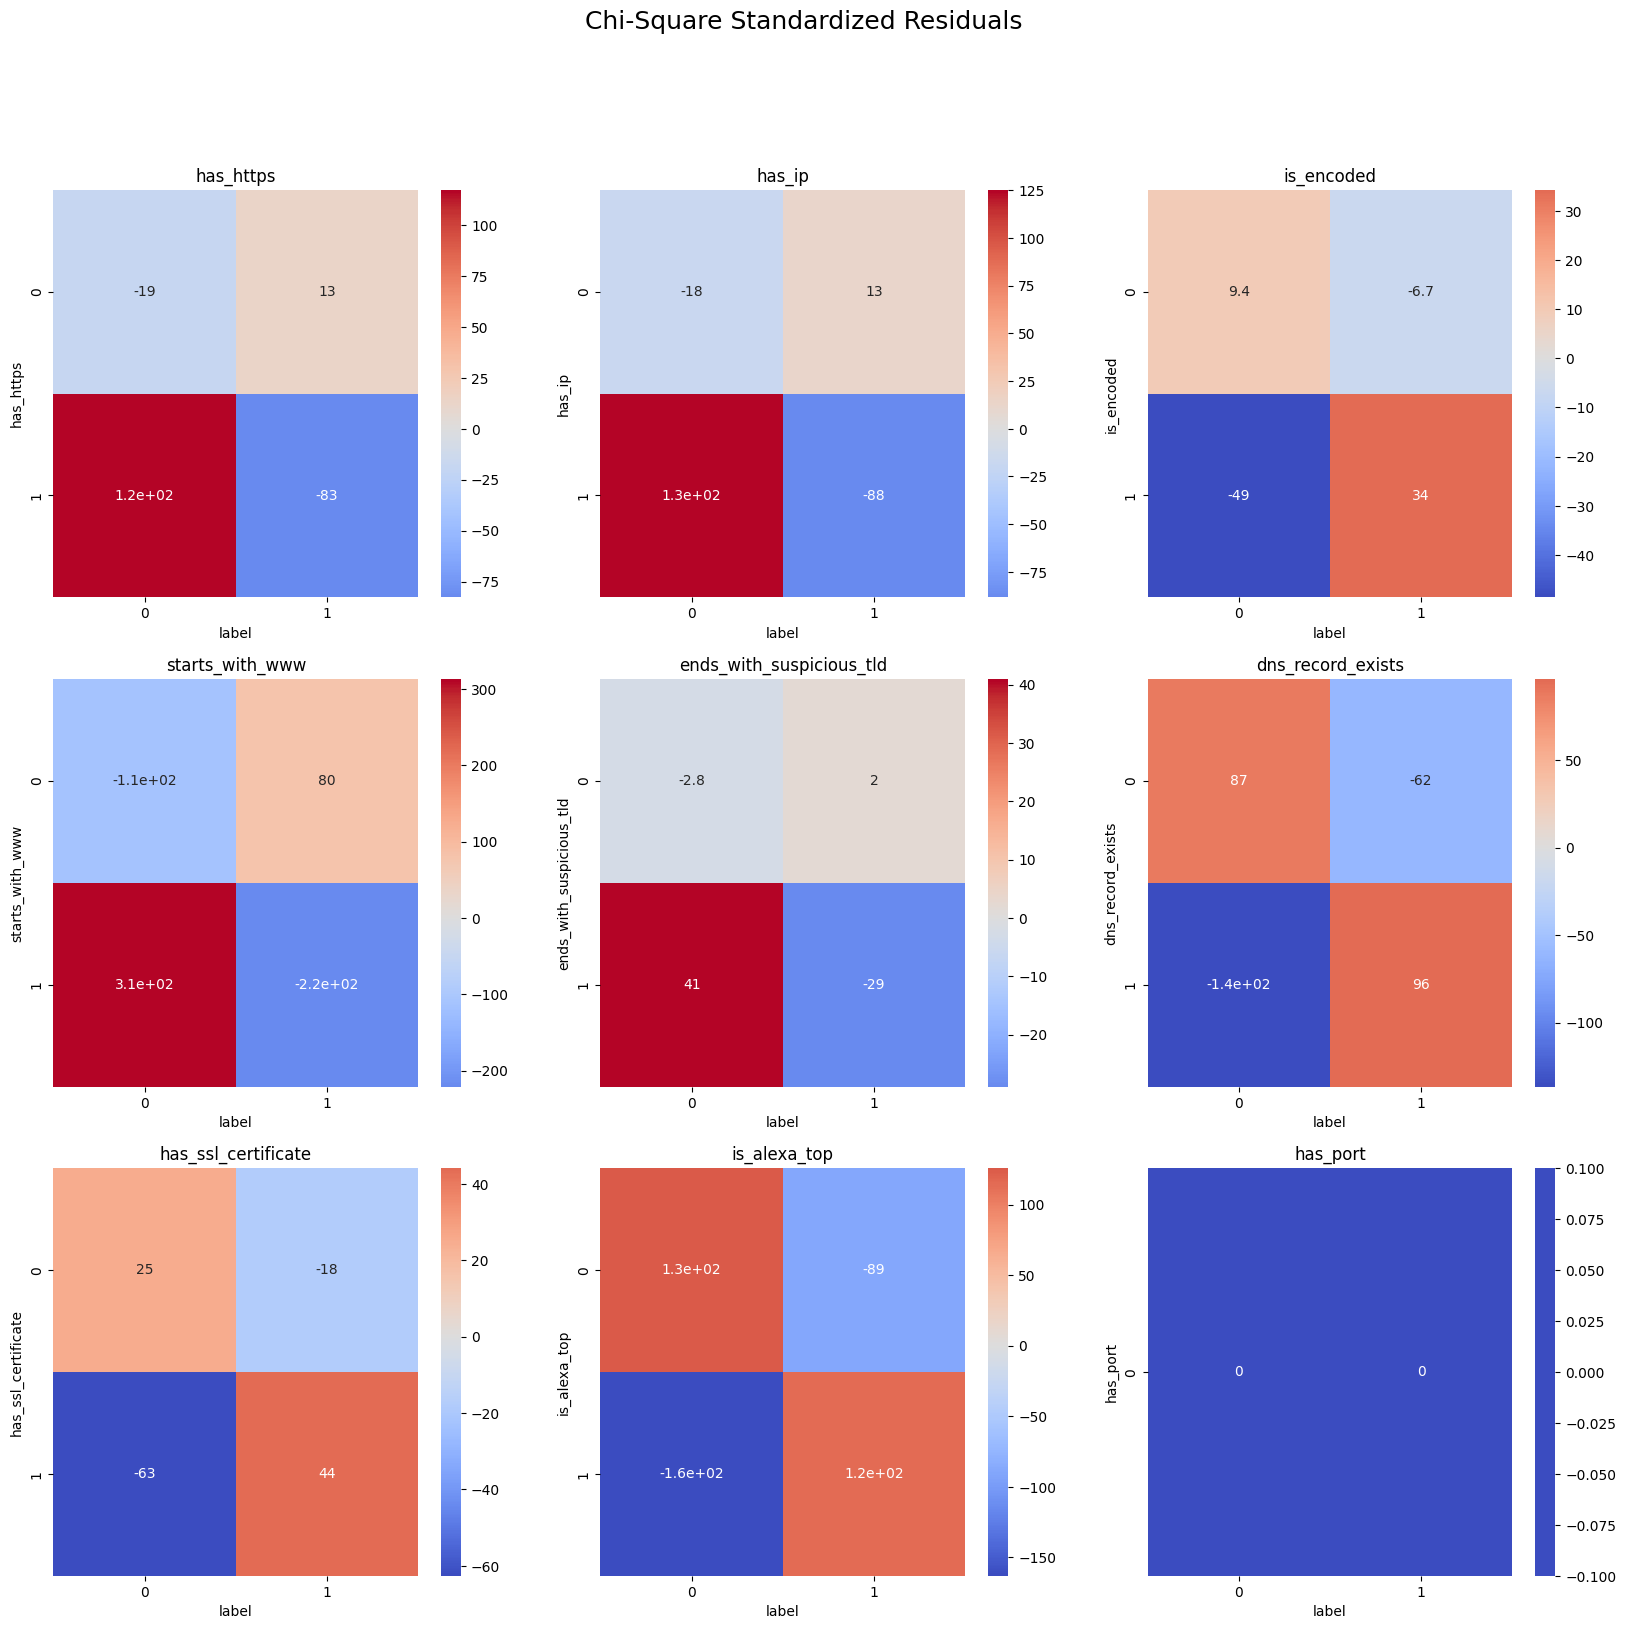

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency
bool_cols = ['has_https','has_ip','is_encoded','starts_with_www','ends_with_suspicious_tld','dns_record_exists','has_ssl_certificate', 'is_alexa_top','has_port']
r=len(bool_cols)//3 + len(bool_cols)%3
fig, axes = plt.subplots(3, r, figsize=(20, 6*r))
fig.suptitle("Chi-Square Standardized Residuals", fontsize=18)
for idx,col in enumerate(bool_cols):
  ax = axes[idx // r, idx % r]
  # Contingency table
  table = pd.crosstab(extracted_dataset[col], extracted_dataset['label'])

  # Chi-square test
  chi2, p, dof, expected = chi2_contingency(table)

  # Residuals
  residuals = (table - expected) / expected**0.5
  #print("Standardized residuals:\n", residuals)
  import seaborn as sns
  import matplotlib.pyplot as plt

  sns.heatmap(residuals, annot=True, cmap='coolwarm', center=0,ax=ax)
  ax.set_title(col, fontsize=12)
plt.show()

             feature  spearman_rho        p_value
0         url_length     -0.068554   0.000000e+00
1    hostname_length     -0.211001   0.000000e+00
2           num_dots     -0.407859   0.000000e+00
3        num_hyphens      0.096642   0.000000e+00
4        num_subdirs     -0.193837   0.000000e+00
5         num_digits      0.000892   4.748187e-01
6         num_params     -0.181446   0.000000e+00
7      num_fragments     -0.025948   6.333665e-96
8      num_uppercase      0.065068   0.000000e+00
9   suspicious_words      0.012389   3.372915e-23
10   domain_age_days     -0.046387  2.530498e-302


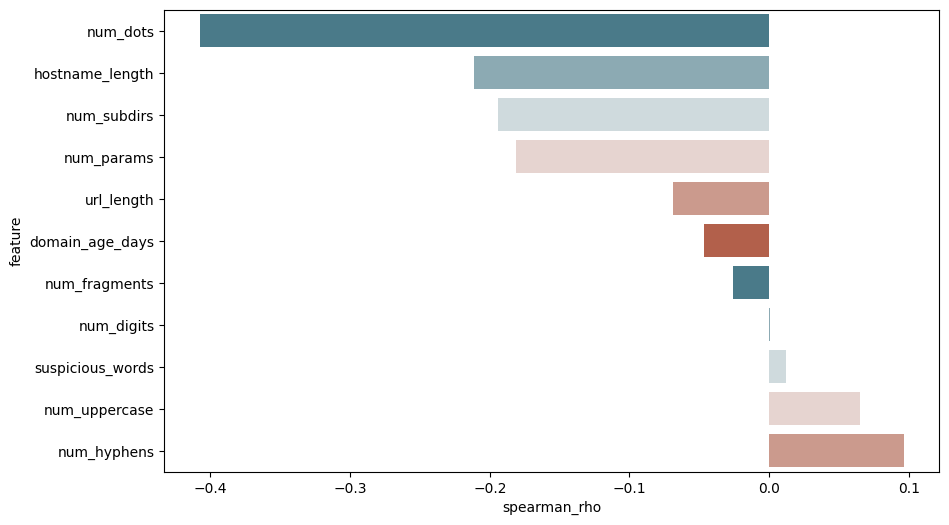

In [ ]:
from scipy.stats import spearmanr

ordinal_cols = ['url_length','hostname_length', 'num_dots', 'num_hyphens','num_subdirs', 'num_digits', 'num_params', 'num_fragments','num_uppercase', 'suspicious_words', 'domain_age_days']
results = []

for col in ordinal_cols:
    rho, p = spearmanr(extracted_dataset[col], extracted_dataset['label'])
    results.append({
        'feature': col,
        'spearman_rho': rho,
        'p_value': p
    })

# Convert to DataFrame and sort
results_df = pd.DataFrame(results)
print(results_df)
# Sort by correlation
results_df.sort_values('spearman_rho', inplace=True)

# Plot
plt.figure(figsize=(10, 6))
bar = sns.barplot(
    x='spearman_rho',
    y='feature',
    data=results_df,
    palette=sns.diverging_palette(220, 20, as_cmap=False)
)
plt.show()



#### Final selected columns

In [ ]:
light_df = extracted_dataset[['has_ip', 'is_encoded', 'ends_with_suspicious_tld', 'dns_record_exists', 'has_ssl_certificate', 'is_alexa_top', 'url_length','hostname_length', 'num_dots','num_subdirs', 'num_params', 'num_fragments','label']]
light_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641209 entries, 0 to 641208
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   has_ip                    641209 non-null  int64
 1   is_encoded                641209 non-null  int64
 2   ends_with_suspicious_tld  641209 non-null  int64
 3   dns_record_exists         641209 non-null  int64
 4   has_ssl_certificate       641209 non-null  int64
 5   is_alexa_top              641209 non-null  int64
 6   url_length                641209 non-null  int64
 7   hostname_length           641209 non-null  int64
 8   num_dots                  641209 non-null  int64
 9   num_subdirs               641209 non-null  int64
 10  num_params                641209 non-null  int64
 11  num_fragments             641209 non-null  int64
 12  label                     641209 non-null  int64
dtypes: int64(13)
memory usage: 63.6 MB


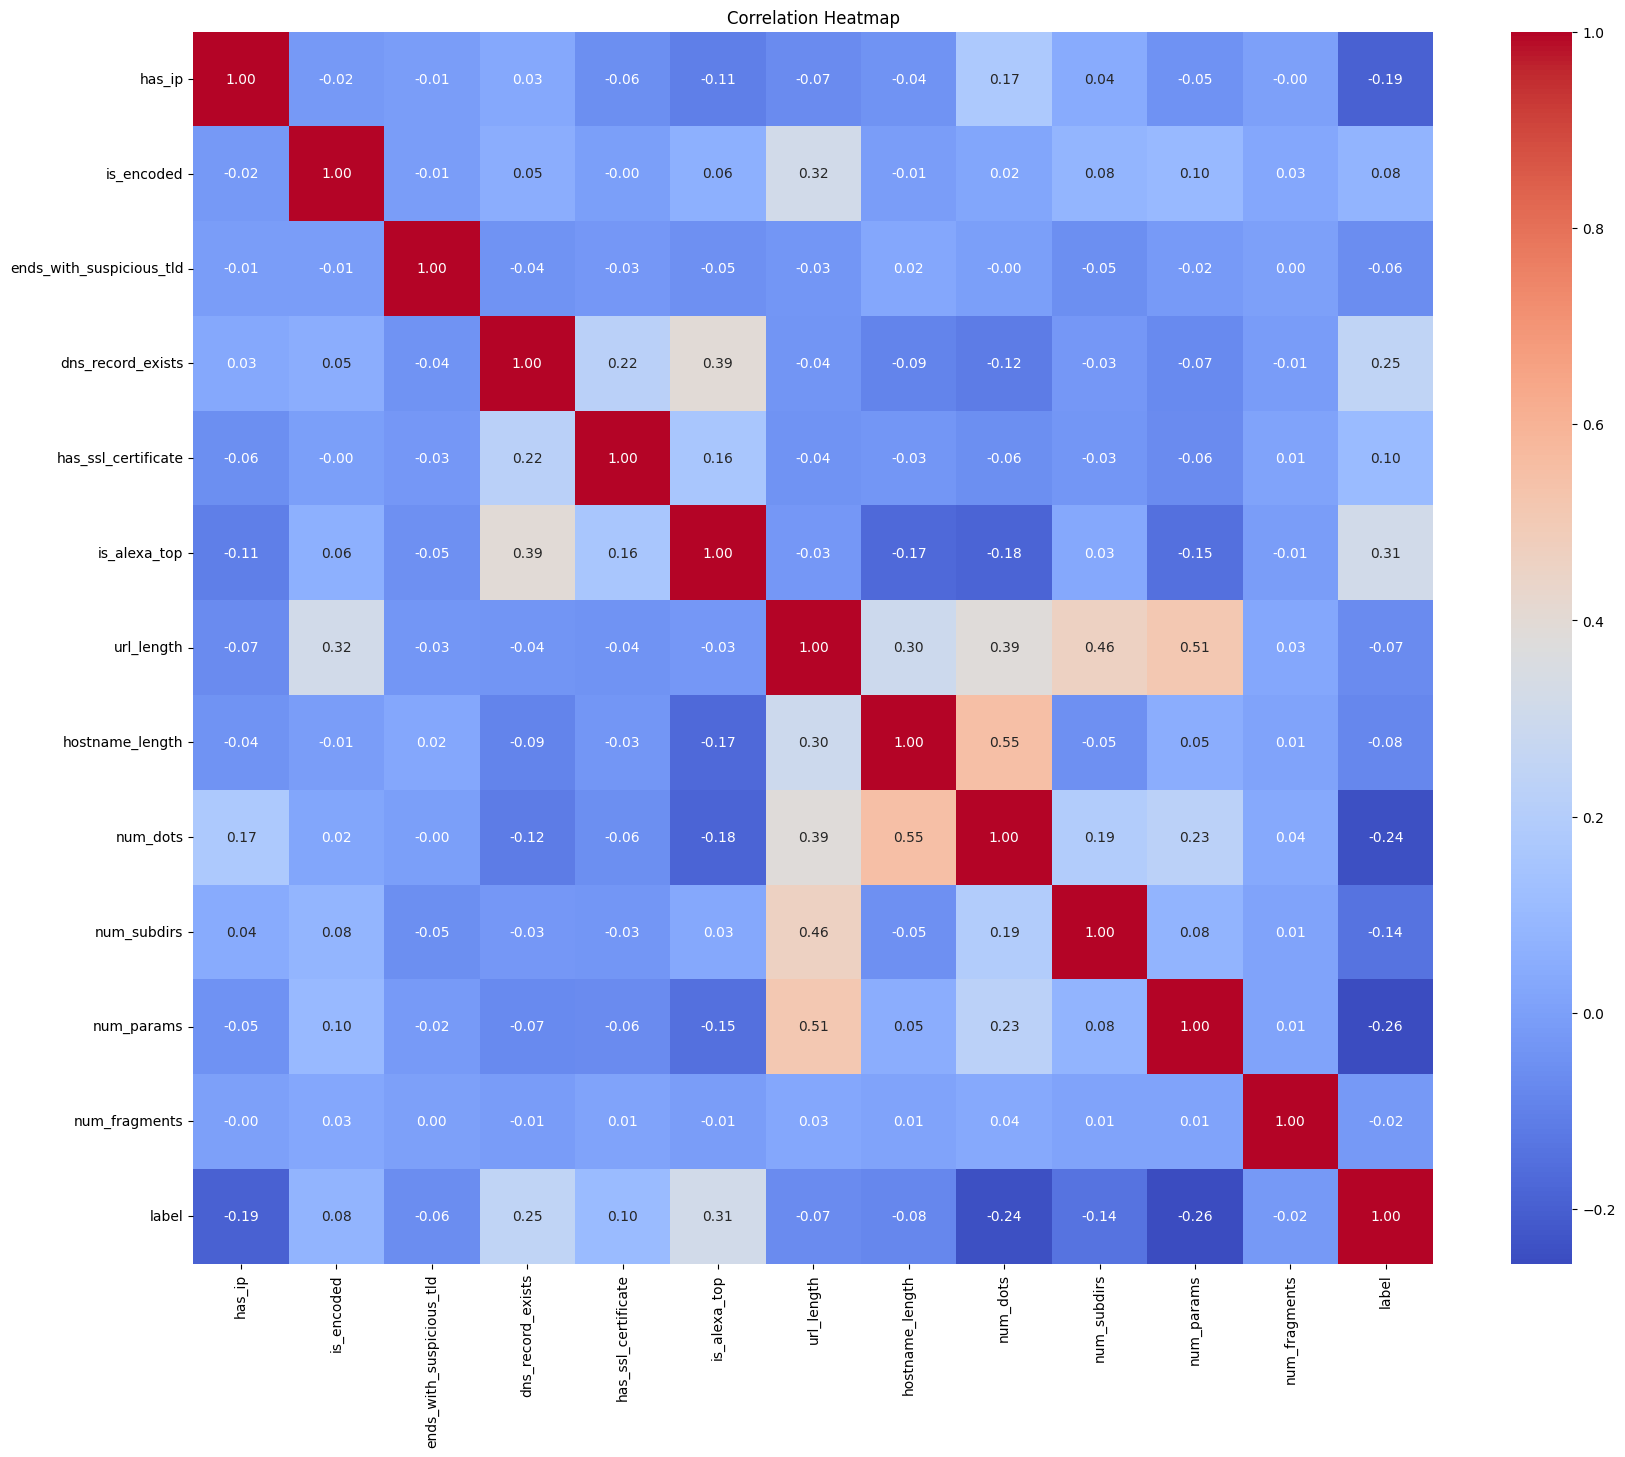

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation = light_df.corr()
correlation.fillna(0,inplace=True)
f=open("final_corr.csv",'w')
f.write(correlation.to_csv())
f.close()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
light_df.to_csv(os.path.join(drive_path,"final_light_dataset.csv"),index=False)

# **Step 3 Traning and Evaluation of model**

#### importing library

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import pickle
import numpy as np
import matplotlib.pyplot as plt

#### importing cv files and Select Independent and Dependent Features

In [ ]:
df = pd.read_csv(os.path.join(drive_path,"final_light_dataset.csv"))
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,has_ip,is_encoded,ends_with_suspicious_tld,dns_record_exists,has_ssl_certificate,is_alexa_top,url_length,hostname_length,num_dots,num_subdirs,num_params,num_fragments,label
0,0,0,0,1,0,0,43,21,1,2,0,0,1
1,0,0,0,0,0,0,34,19,2,2,0,0,1
2,0,0,0,0,0,0,53,11,2,4,1,0,0
3,0,0,0,0,0,0,35,9,1,3,0,0,1
4,0,0,0,1,1,1,57,11,1,4,0,0,1


In [ ]:
independent_features = df.columns.tolist()
independent_features.remove("label")
dependent_features = ["label"]



### Perform stratified k-fold cross-validation on Random Forest, collect metrics and average feature importances

#### Perform stratified k-fold cross-validation


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from xgboost import XGBClassifier

In [ ]:
RFmodel = RandomForestClassifier(n_estimators=100,
    min_samples_split=100,
    random_state=42)
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# For storing metrics
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
feature_importances = []
confusion_matrix_cv = []
proba_list = []
thresholds = np.arange(0.1, 0.91, 0.1)  # Try thresholds from 0.1 to 0.9
threshold_metrics = {th: {'accuracy': [], 'precision': [], 'recall': [], 'f1': []} for th in thresholds}
x=0
# Cross-validation loop
for train_index, val_index in skf.split(df[independent_features], df[dependent_features]):
    print('\r','|'+('#'*x+'=').ljust(5,'_')+'|',str(20*x)+'%',end='')
    X_tr, X_val = df[independent_features].iloc[train_index], df[independent_features].iloc[val_index]
    y_tr, y_val = df[dependent_features].iloc[train_index], df[dependent_features].iloc[val_index]

    RFmodel.fit(X_tr, y_tr.values.ravel())
    y_pred = RFmodel.predict(X_val)
    y_proba = RFmodel.predict_proba(X_val)[:, 0]

    for th in thresholds:
        y_pred_thresh = (y_proba <= th).astype(int)

        threshold_metrics[th]['accuracy'].append(accuracy_score(y_val, y_pred_thresh))
        threshold_metrics[th]['precision'].append(precision_score(y_val, y_pred_thresh, zero_division=0))
        threshold_metrics[th]['recall'].append(recall_score(y_val, y_pred_thresh))
        threshold_metrics[th]['f1'].append(f1_score(y_val, y_pred_thresh))
    # Feature importances
    feature_importances.append(RFmodel.feature_importances_)
    x+=1
    print('\r','|'+('#'*x).ljust(5,'_')+'|',str(20*x)+'%',end='')
# Average feature importance
avg_feature_importance = np.mean(feature_importances, axis=0)
feature_df = pd.DataFrame({
    'Feature': independent_features,
    'Avg Importance': avg_feature_importance
}).sort_values(by='Avg Importance', ascending=False)

# Display average metrics per threshold
print("\nMetrics at Various Probability Thresholds:\n")
for th in thresholds:
    print(f"Threshold = {th:.2f}")
    print(f"  Accuracy : {np.mean(threshold_metrics[th]['accuracy']):.4f}")
    print(f"  Precision: {np.mean(threshold_metrics[th]['precision']):.4f}")
    print(f"  Recall   : {np.mean(threshold_metrics[th]['recall']):.4f}")
    print(f"  F1 Score : {np.mean(threshold_metrics[th]['f1']):.4f}")
    print("-" * 40)

 |#####| 100%
Metrics at Various Probability Thresholds:

Threshold = 0.10
  Accuracy : 0.8359
  Precision: 0.9896
  Recall   : 0.7621
  F1 Score : 0.8611
----------------------------------------
Threshold = 0.20
  Accuracy : 0.8847
  Precision: 0.9800
  Recall   : 0.8446
  F1 Score : 0.9073
----------------------------------------
Threshold = 0.30
  Accuracy : 0.9062
  Precision: 0.9692
  Recall   : 0.8877
  F1 Score : 0.9267
----------------------------------------
Threshold = 0.40
  Accuracy : 0.9161
  Precision: 0.9557
  Recall   : 0.9169
  F1 Score : 0.9359
----------------------------------------
Threshold = 0.50
  Accuracy : 0.9190
  Precision: 0.9394
  Recall   : 0.9393
  F1 Score : 0.9393
----------------------------------------
Threshold = 0.60
  Accuracy : 0.9142
  Precision: 0.9176
  Recall   : 0.9576
  F1 Score : 0.9371
----------------------------------------
Threshold = 0.70
  Accuracy : 0.8990
  Precision: 0.8859
  Recall   : 0.9741
  F1 Score : 0.9279
-----------------

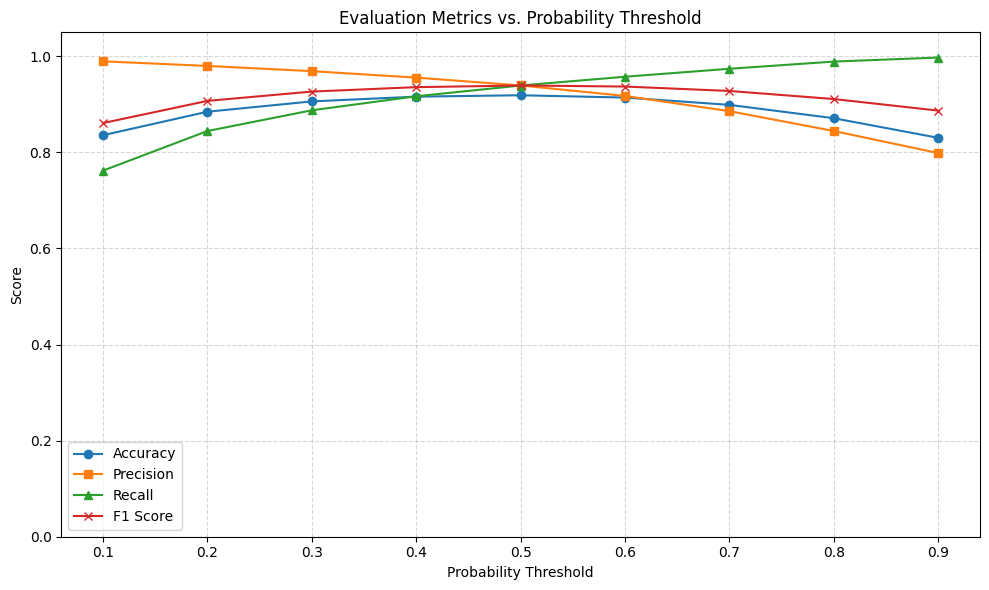

In [ ]:
import matplotlib.pyplot as plt

# Extract averaged metrics from dictionary
accs = [np.mean(threshold_metrics[th]['accuracy']) for th in thresholds]
prec = [np.mean(threshold_metrics[th]['precision']) for th in thresholds]
rec = [np.mean(threshold_metrics[th]['recall']) for th in thresholds]
f1s = [np.mean(threshold_metrics[th]['f1']) for th in thresholds]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accs, marker='o', label='Accuracy')
plt.plot(thresholds, prec, marker='s', label='Precision')
plt.plot(thresholds, rec, marker='^', label='Recall')
plt.plot(thresholds, f1s, marker='x', label='F1 Score')

plt.title('Evaluation Metrics vs. Probability Threshold')
plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.xticks(thresholds)
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


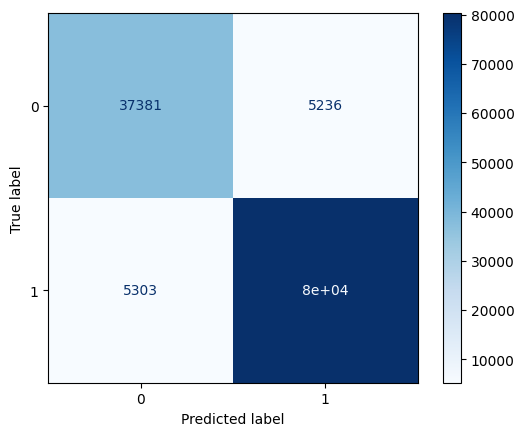

In [ ]:
# Confusion Matrix Display
ConfusionMatrixDisplay(confusion_matrix_cv[0]).plot(cmap='Blues')

#### Feature Importance Plot

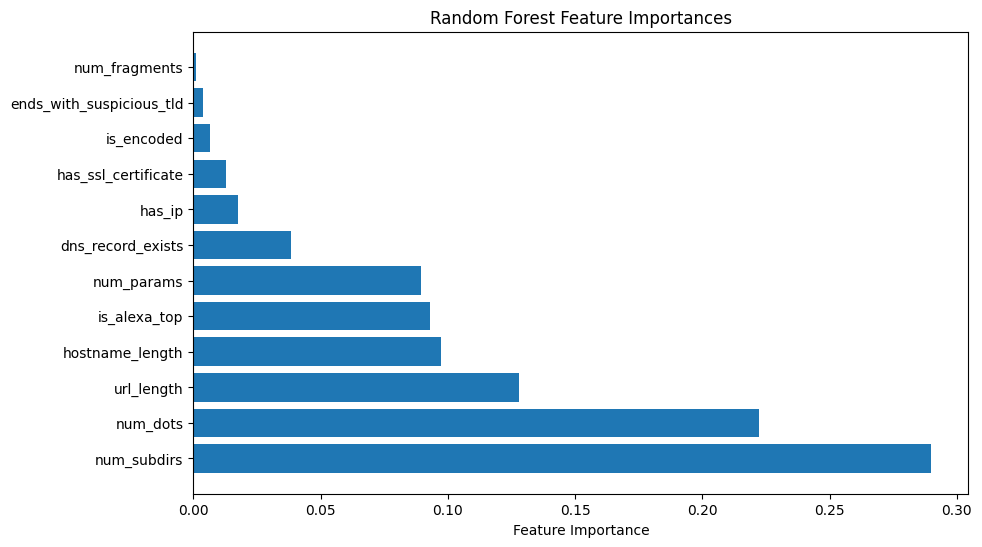

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'],feature_df['Avg Importance'], align='center')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.show()


### Final Random Forest Classifier Model

In [ ]:
RFmodel = RandomForestClassifier(n_estimators=100,
    min_samples_split=100,
    random_state=42)
RFmodel.fit(df[independent_features], df[dependent_features])


RandomForestClassifier(min_samples_split=100, random_state=42)

In [ ]:
# Save the Trained Model using Pickle
with open(os.path.join(drive_path,"random_forest_model.pkl"), "wb") as f:
  pickle.dump(RFmodel, f)
  pickle.dump(independent_features, f)

# User input prediction

In [ ]:
import pickle
import shap
import pandas as pd

In [ ]:
# Load model from pkl file
with open(os.path.join(drive_path,"random_forest_model.pkl"), "rb") as f:
  RFmodel = pickle.load(f)
  independent_features = pickle.load(f)

In [ ]:
def user_input_prediction(user_url):

  features_dict = extract_all_features(user_url)
  print(pd.DataFrame([features_dict]).to_string(index=False))

  prediction = RFmodel.predict_proba(pd.DataFrame([features_dict])[independent_features])
  print(prediction)
  return "safe" if (prediction[0][0] < 0.70) else "malicious: ",features_dict

In [ ]:
user_url = input("Enter a URL to check if it's safe or malicious: ").strip()
predicted_class,features_dict = user_input_prediction(user_url)
print(f" The entered {user_url} is classified as: **{predicted_class.upper()}**")

Enter a URL to check if it's safe or malicious: https://web.whatsapp.com/
                      url       domain  url_length  hostname_length  num_dots  num_hyphens  has_https  num_subdirs  num_digits  num_params  num_fragments  num_uppercase  has_ip  has_port  is_encoded  starts_with_www  ends_with_suspicious_tld  suspicious_words  domain_age_days  dns_record_exists  has_ssl_certificate  is_alexa_top
https://web.whatsapp.com/ whatsapp.com          25               16         2            0          1            3           0           0              0              0       0         0           0                0                         0                 0             6169                  1                    1             1
[[0.65952696 0.34047304]]
 The entered https://web.whatsapp.com/ is classified as: **SAFE**


In [ ]:
user_url = input("Enter a URL to check if it's safe or malicious: ").strip()
predicted_class,features_dict = user_input_prediction(user_url)
print(f" The entered {user_url} is classified as: **{predicted_class.upper()}**")

Enter a URL to check if it's safe or malicious: 	http://allegrolokalnie.pl-oferta3848403.sbs
                                        url               domain  url_length  hostname_length  num_dots  num_hyphens  has_https  num_subdirs  num_digits  num_params  num_fragments  num_uppercase  has_ip  has_port  is_encoded  starts_with_www  ends_with_suspicious_tld  suspicious_words  domain_age_days  dns_record_exists  has_ssl_certificate  is_alexa_top
http://allegrolokalnie.pl-oferta3848403.sbs pl-oferta3848403.sbs          43               36         2            1          0            2           7           0              0              0       0         0           0                0                         0                 0                0                  1                    1             0
[[0.65294457 0.34705543]]
 The entered http://allegrolokalnie.pl-oferta3848403.sbs is classified as: **SAFE**


In [ ]:


sample_df = pd.DataFrame([features_dict])[independent_features]

explainer = shap.TreeExplainer(RFmodel)
shap_values = explainer.shap_values(sample_df)

# Binary classification: shap_values[1] = impact on class 1 (safe)
# Print SHAP values per feature
print("Feature contributions toward 'safe' (class 1):")
print(shap_values)
for i, feature in enumerate(independent_features):
    print(f"- {feature}:{features_dict[feature]}: {shap_values[0][i][1]:.4f}")


Feature contributions toward 'safe' (class 1):
[[[-1.99457615e-03  1.99457615e-03]
  [ 3.33912952e-03 -3.33912952e-03]
  [-5.25076291e-04  5.25076291e-04]
  [ 9.60295115e-03 -9.60295115e-03]
  [ 2.96285740e-02 -2.96285740e-02]
  [ 1.07521669e-01 -1.07521669e-01]
  [ 1.35113520e-02 -1.35113520e-02]
  [ 1.95444909e-01 -1.95444909e-01]
  [ 2.76359275e-02 -2.76359275e-02]
  [-6.67411806e-02  6.67411806e-02]
  [ 3.46215323e-03 -3.46215323e-03]
  [-1.56455487e-04  1.56455487e-04]]]
- has_ip:0: 0.0020
- is_encoded:0: -0.0033
- ends_with_suspicious_tld:0: 0.0005
- dns_record_exists:1: -0.0096
- has_ssl_certificate:1: -0.0296
- is_alexa_top:0: -0.1075
- url_length:43: -0.0135
- hostname_length:36: -0.1954
- num_dots:2: -0.0276
- num_subdirs:2: 0.0667
- num_params:0: -0.0035
- num_fragments:0: 0.0002
